In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib

pd.set_option('display.max_columns', 120)
plt.rcParams['figure.figsize'] = (10,4)
sns.set_style('whitegrid')

print("Done loading libraries")


Done loading libraries


In [3]:
# Load data
CSV_PATH = "netflix1.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("Put netflix_titles.csv in /mnt/data or change CSV_PATH")

data = pd.read_csv(CSV_PATH)
print("Rows, columns:", data.shape)
data.head()



Rows, columns: (8790, 10)


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [4]:
# Quick check
print("Columns:", data.columns.tolist())
print("\nMissing values (top):")
print(data.isnull().sum().sort_values(ascending=False).head(20))
print("\nDuplicates:", data.duplicated().sum())


Columns: ['show_id', 'type', 'title', 'director', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in']

Missing values (top):
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

Duplicates: 0


In [5]:
# Normalize names and convert dates
data.columns = [c.strip().lower().replace(' ', '_') for c in data.columns]
if 'date_added' in data.columns:
    data['date_added'] = pd.to_datetime(data['date_added'].astype(str), errors='coerce')
print("Columns normalized. Sample:")
data.head(3)


Columns normalized. Sample:


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"


In [6]:
# Clean strings and drop duplicates
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype(str).str.strip().replace({'': np.nan, 'nan': np.nan})

before = len(data)
data.drop_duplicates(inplace=True)
print("Dropped", before - len(data), "duplicate rows")


Dropped 0 duplicate rows


In [7]:
# Extract duration and genres
if 'duration' in data.columns:
    data['duration_min'] = data['duration'].str.extract(r'(\d+)\s*min', expand=False)
    data['duration_min'] = pd.to_numeric(data['duration_min'], errors='coerce')
    data['seasons'] = data['duration'].str.extract(r'(\d+)\s*Season', expand=False)
    data['seasons'] = pd.to_numeric(data['seasons'], errors='coerce').fillna(0).astype(int)

if 'listed_in' in data.columns:
    data['genres'] = data['listed_in'].apply(lambda x: [g.strip() for g in str(x).split(',') if g.strip()])
    data['top_genre'] = data['genres'].apply(lambda l: l[0] if l else np.nan)

print("Duration and genre columns added.")
display(data[['title','duration','duration_min','seasons','top_genre']].head())


Duration and genre columns added.


,title,duration,duration_min,seasons,top_genre
0,Dick Johnson Is Dead,90 min,90.0,0,Documentaries
1,Ganglands,1 Season,NaN,1,Crime TV Shows
2,Midnight Mass,1 Season,NaN,1,TV Dramas
3,Confessions of an Invisible Girl,91 min,91.0,0,Children & Family Movies
4,Sankofa,125 min,125.0,0,Dramas


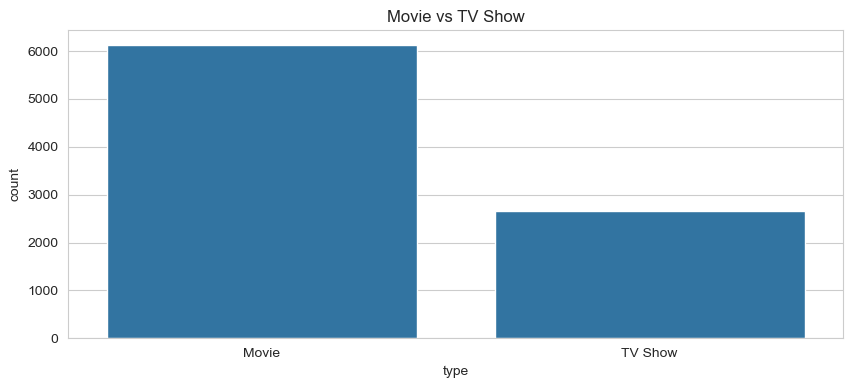

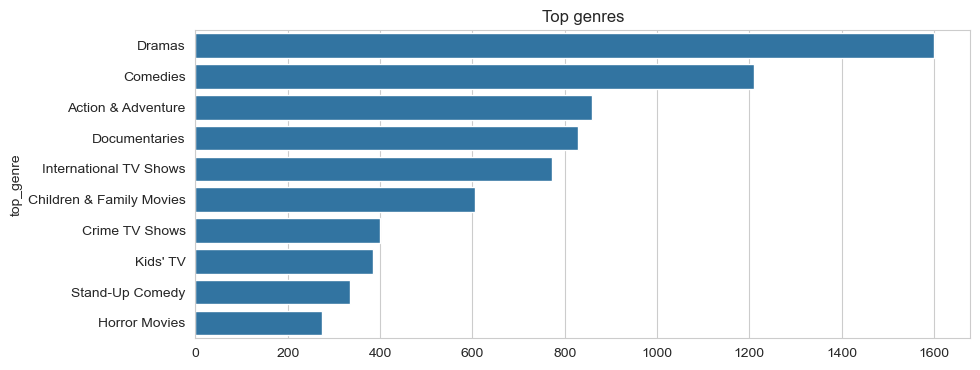

In [8]:
# Basic plots
# Count movies vs tv shows
if 'type' in data.columns:
    sns.countplot(x='type', data=data, order=data['type'].value_counts().index)
    plt.title('Movie vs TV Show')
    plt.show()

# Top genres
if 'top_genre' in data.columns:
    top = data['top_genre'].value_counts().head(10)
    sns.barplot(x=top.values, y=top.index)
    plt.title('Top genres')
    plt.show()


In [9]:
# Simple ML demo - predict movie vs tv show
data_ml = data.copy()
data_ml['is_movie'] = data_ml['type'].apply(lambda x: 1 if str(x).lower().strip()=='movie' else 0)
features = [c for c in ['duration_min','seasons'] if c in data_ml.columns]
data_ml = data_ml[features + ['is_movie']].fillna(0)

X = data_ml[features]
y = data_ml['is_movie']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_s, y_train)
preds = clf.predict(X_test_s)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00      1225

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758

